## MG-GY 8401: Programming for Business Intelligence and Analytics
### Lab 7

In this lab, we will get experience with web-scraping. We want to understand the use of `requests`, `bs4` and `lxml` for 

1. Establishing a connection to the internet
1. Fetching content of a website
1. Parsing data in XML format
  
Unlike Lecture 7, we will be focusing on eXtensible Markup Language which generalize HyperText Markup Language. Note that Python has several versions. We will be using **Python 3.7**.

In [1]:
# import some packages

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import re

import requests
from lxml import etree
from bs4 import BeautifulSoup

# change some settings

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)
plt.rcParams['figure.figsize'] = (15,6)

We will study the exchange rates between differnt currencies. The European Central Bank maintains exchange rates for the euro.

> https://www.ecb.europa.eu/stats/eurofxref/eurofxref-daily.xml

We want to extract information about three currencies 

- British pound (GBP)
- US dollar (USD)
- Canadian dollar (CAD)

We will plot the movement of the exchange rates over time.

#### Establishing a Connecting 

We will use `requests` package to send a GET request. 

In [8]:
url = 'https://www.ecb.europa.eu/stats/eurofxref/eurofxref-hist-90d.xml?d574942462c9e687c3235ce020466aae'
response = requests.get(url)

We can check the status code.

In [9]:
response.status_code

200

Remember that any status code starting with the digit 2 means valid request and response.

In [10]:
for key in response.headers:
    print(f"{key} : {response.headers[key]}")

Server : myracloud
Date : Thu, 21 Jan 2021 21:09:17 GMT
Content-Type : text/xml
Transfer-Encoding : chunked
Connection : keep-alive
X-Frame-Options : SAMEORIGIN
Strict-Transport-Security : max-age=63072000; includeSubDomains
Last-Modified : Thu, 21 Jan 2021 14:55:11 GMT
X-XSS-Protection : 1; mode=block
Expires : Thu, 21 Jan 2021 21:10:53 GMT
cache-control : max-age=300
X-CDN : 1


The header indicates that the data in the body of the response is XML. Note that XML is an acronymn for eXtensible Mark-up Language. Both XML and HTML contains elements in a tree-like structure with 

- tags
- text 
- attributes 

However, HTML has standardized values for tags and attributes. The tags and attributes in XML are arbitrary without specification of a schema. A schema indicates the allowable values in the elements. 

In [11]:
response.content[:1000]

b'<?xml version="1.0" encoding="UTF-8"?><gesmes:Envelope xmlns:gesmes="http://www.gesmes.org/xml/2002-08-01" xmlns="http://www.ecb.int/vocabulary/2002-08-01/eurofxref"><gesmes:subject>Reference rates</gesmes:subject><gesmes:Sender><gesmes:name>European Central Bank</gesmes:name></gesmes:Sender><Cube><Cube time="2021-01-21"><Cube currency="USD" rate="1.2158"/><Cube currency="JPY" rate="125.72"/><Cube currency="BGN" rate="1.9558"/><Cube currency="CZK" rate="26.094"/><Cube currency="DKK" rate="7.4395"/><Cube currency="GBP" rate="0.88625"/><Cube currency="HUF" rate="357.38"/><Cube currency="PLN" rate="4.5284"/><Cube currency="RON" rate="4.874"/><Cube currency="SEK" rate="10.0825"/><Cube currency="CHF" rate="1.0773"/><Cube currency="ISK" rate="156.8"/><Cube currency="NOK" rate="10.2513"/><Cube currency="HRK" rate="7.565"/><Cube currency="RUB" rate="89.6369"/><Cube currency="TRY" rate="8.9555"/><Cube currency="AUD" rate="1.5635"/><Cube currency="BRL" rate="6.4073"/><Cube currency="CAD" rate=

#### Parsing the Data

We can use the `bs4` package to parse the data. 

In [12]:
soup = BeautifulSoup(response.content, 'xml')

Before we extract information, we should look through the data

+ Where is the currency and exchange rate? 
+ Where is the date? 
+ How nested are the elements in the tree?

The above link provides the daily conversion rates. Below we provide the `url` of the recorded history, over 4,800 days. Run the following code to send a request for the content at this url. 

In [14]:
print(soup.prettify())

<?xml version="1.0" encoding="utf-8"?>
<gesmes:Envelope xmlns="http://www.ecb.int/vocabulary/2002-08-01/eurofxref" xmlns:gesmes="http://www.gesmes.org/xml/2002-08-01">
 <gesmes:subject>
  Reference rates
 </gesmes:subject>
 <gesmes:Sender>
  <gesmes:name>
   European Central Bank
  </gesmes:name>
 </gesmes:Sender>
 <Cube>
  <Cube time="2021-01-21">
   <Cube currency="USD" rate="1.2158"/>
   <Cube currency="JPY" rate="125.72"/>
   <Cube currency="BGN" rate="1.9558"/>
   <Cube currency="CZK" rate="26.094"/>
   <Cube currency="DKK" rate="7.4395"/>
   <Cube currency="GBP" rate="0.88625"/>
   <Cube currency="HUF" rate="357.38"/>
   <Cube currency="PLN" rate="4.5284"/>
   <Cube currency="RON" rate="4.874"/>
   <Cube currency="SEK" rate="10.0825"/>
   <Cube currency="CHF" rate="1.0773"/>
   <Cube currency="ISK" rate="156.8"/>
   <Cube currency="NOK" rate="10.2513"/>
   <Cube currency="HRK" rate="7.565"/>
   <Cube currency="RUB" rate="89.6369"/>
   <Cube currency="TRY" rate="8.9555"/>
   <Cube

First we can extract the dates. Note that the date appears in the format 

> `YYYY-MM-DD`

in the `time` attribute of elements with tag `Cube`.

In [9]:
soup_times = soup.find_all('Cube', {"time" : re.compile(r"\d+-\d+-\d+")})

Here we look for elements with the tag `Cube`. We use a regular expression to limit the search to elements with a `time` attribute. Moreover the value of the `time` attribute must contain three numbers seperated by dashes.

In [10]:
times = []
for time in soup_times:
    times.append(time.get("time"))

Note that we have 64 different dates.

In [11]:
len(times)

64

Second we can extract the exchange rates. Note that the exchange rate occurs in attribute `rate` of an element with tag `Cube`. Additionally the element has an attribute `currency` indicating the currency. 

In [12]:
soup_rates = soup.find_all('Cube', {"currency" : "USD"})
soup_rates[0]

<Cube currency="USD" rate="1.1799"/>

We can extract the rate with the `get` function.

In [13]:
soup_rates[0].get("rate")

'1.1799'

Repeating for `CAD` and `GBP`, we have the three currencies needed for the chart.

In [15]:
currency_rates = dict()

for currency in ["USD", "CAD", "GBP"]:
    soup_rates = soup.find_all('Cube', {"currency" : currency})

    rates = []
    for rate in soup_rates:
        rates.append(rate.get("rate"))
        
    currency_rates[currency] = rates

Now we can generate a table.

In [16]:
table = pd.DataFrame(currency_rates)
table.index = times
table

,USD,CAD,GBP
2020-10-12,1.1799,1.5493,0.90598
2020-10-09,1.1795,1.5542,0.91167
2020-10-08,1.1765,1.5583,0.91035
2020-10-07,1.177,1.564,0.91413
2020-10-06,1.1795,1.563,0.91058
...,...,...,...
2020-07-21,1.1443,1.5399,0.90055
2020-07-20,1.1448,1.5532,0.90575
2020-07-17,1.1428,1.551,0.91078
2020-07-16,1.1414,1.5452,0.90875


We need to convert the data types

In [17]:
table.index = pd.to_datetime(table.index, format = "%Y-%m-%d")
table = table.astype(float)

Now we can plot the data.

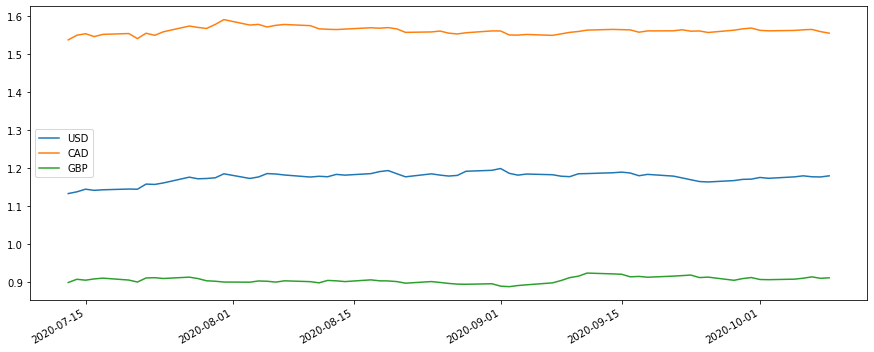

In [17]:
table.plot();

#### Parsing the Data with XPath

We can use the `lxml` package to leverage XPath. Remember that XPath allows us to search data with a Document Object Model (DOM). The DOM is a tree-like structure consisting of elements.

In [24]:
dom = etree.fromstring(response.content) 

Unlike the demonstration from Lecture 7, we cannot use the `html` module of the `lxml` package because the data has the XML format not the HTML format.

In [25]:
dom.tag

'{http://www.gesmes.org/xml/2002-08-01}Envelope'

Note that the `Envelope` tag has an attribute called `xmlns`. The attribute refers to a namespace. A namespace helps us to identify the tags and attributes of elements. Moreover the namespace can provide a schema to help us interpret the tags and attributes of the elements. 

In [26]:
namespaceURI = 'http://www.ecb.int/vocabulary/2002-08-01/eurofxref'

Here the namespace refers to `gesmes` which an international standard for the exchange of panel data. Note that we have two namespaces. Beside `gemes` we have a namespace maintained by the European Central Bank. We use a URL to link to the data in the namespace. 

In [27]:
times = dom.xpath('.//x:Cube/@time', namespaces = {'x':namespaceURI}) 
times[:5]

['2020-10-12', '2020-10-09', '2020-10-08', '2020-10-07', '2020-10-06']

We want to extract the dates. We search from the root of the tree for elements with the tag `Cube`. 

Here we denote the namespace with `x`. So we use `x:Cube` to specify that `Cube` is a special tag contained in the namespace.

In [29]:
rateGBP = dom.xpath('.//x:Cube[@currency = "GBP"]/@rate', namespaces = {'x':namespaceURI})
rateGBP[:5]

['0.90598', '0.91167', '0.91035', '0.91413', '0.91058']

We can access the exchange rates with an XPath search for elements with the tag `Cube` containing `currency` attribute. We specify a logical expression within brackets to filter by `USD`,`CAD` and `GBP`. Having located the elements, we can extract the rate from the `rate` attribute.


In [30]:
rateUSD = dom.xpath('.//x:Cube[@currency = "USD"]/@rate', namespaces = {'x':namespaceURI}) 
rateCAD = dom.xpath('.//x:Cube[@currency = "CAD"]/@rate', namespaces = {'x':namespaceURI}) 

Now we can generate a table.

In [31]:
table = pd.DataFrame({"USD" : rateUSD, "CAD" : rateCAD, "GBP" : rateGBP}, index = times)
table

,USD,CAD,GBP
2020-10-12,1.1799,1.5493,0.90598
2020-10-09,1.1795,1.5542,0.91167
2020-10-08,1.1765,1.5583,0.91035
2020-10-07,1.177,1.564,0.91413
2020-10-06,1.1795,1.563,0.91058
...,...,...,...
2020-07-21,1.1443,1.5399,0.90055
2020-07-20,1.1448,1.5532,0.90575
2020-07-17,1.1428,1.551,0.91078
2020-07-16,1.1414,1.5452,0.90875


We need to convert the data types

In [32]:
table = table.astype(float)

table.index = table.index.astype(str)
table.index = pd.to_datetime(table.index, format = "%Y-%m-%d")

Now we can plot the data.

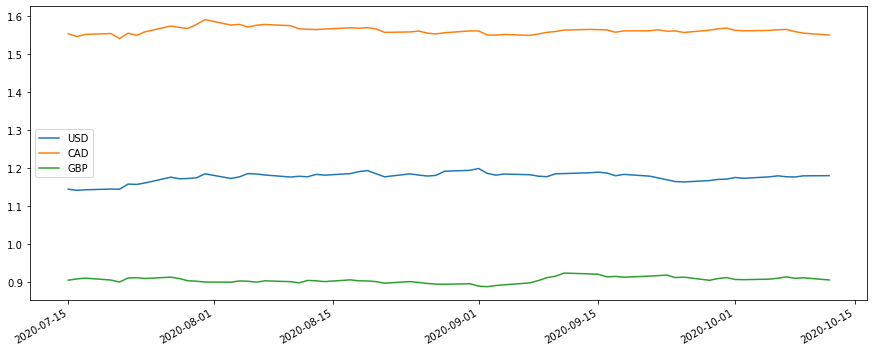

In [33]:
table.plot();

We obtain the same chart.